## US presidential elections model

How do macroeconomic features influence the left/right lean in US presidential elections? 

### Imports

In [1]:
# Misc system tools
from pathlib import Path
import subprocess 
# Data science stuff 
import pandas as pd
import matplotlib.pyplot as plt
# ML models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# Internal modules
from train import Train
from analyse import Analyse

# Apply matplotlib style
style_path = Path(__file__).parent / "plot.mplstyle" if '__file__' in globals() else Path("plot.mplstyle")
plt.style.use(style_path)

## Load preprocessed data

`code/process_data.py` runs preprocessing

Contains merged data from three sources (1960-2020):
- Election outcomes (winner, party, lean, label)
- World Bank macroeconomic indicators (GDP growth, inflation, trade balance, etc.)
- FRED unemployment rates (monthly data aggregated to yearly averages)

Missing values handled by:
- Dropping columns with >50% missing data
- Linear interpolation for remaining gaps
- Dropping any columns that still have missing values after interpolation

In [2]:
file_path = "../data/proc/data.csv" 
if not Path(file_path).is_file():
    subprocess.run(["python3", "process_data.py"])  
df = pd.read_csv(file_path)
display(df)

,Year,Winner,Party,EC,PV,Lean,Era,Label,index,"Population, total",...,Mobile cellular subscriptions (per 100 people),Merchandise trade (% of GDP),Net barter terms of trade index (2015 = 100),Net migration,"Personal remittances, paid (current US$)","Foreign direct investment, net inflows (BoP, current US$)",GDP per capita (current US$),"Foreign direct investment, net (BoP, current US$)","Inflation, consumer prices (annual %)",Unemployment
0,2024,Donald Trump,Republican,0.4200,0.4834,Right,Populist,1,64,334914895,...,104.935375,18.733583,100.000000,1322668,9.303100e+10,3.487840e+11,82769.412210,1.053000e+11,4.116338,4.027273
1,2020,Joseph Biden,Democratic,0.5688,0.5131,Left,Populist,0,61,331526933,...,104.935375,17.944405,100.000000,329769,6.612600e+10,1.370660e+11,64411.373180,1.452650e+11,1.233584,8.091667
2,2016,Donald Trump,Republican,0.5690,0.4620,Right,Populist,1,57,323071755,...,103.370250,19.681904,100.083472,1889129,6.287000e+10,4.743880e+11,58206.614190,-1.745730e+11,1.261583,4.875000
3,2012,Barack Obama,Democratic,0.6170,0.5110,Left,Partisan Polarisation,0,53,313877662,...,96.269297,23.884792,94.680851,1632007,5.237100e+10,2.503450e+11,51784.411470,1.268950e+11,2.069337,8.075000
4,2008,Barack Obama,Democratic,0.6780,0.5290,Left,Partisan Polarisation,0,49,304093966,...,85.477380,23.405290,91.797166,1416841,5.567900e+10,3.410920e+11,48570.059430,2.491000e+09,3.839100,5.800000
5,2004,George W. Bush,Republican,0.5320,0.5070,Right,Partisan Polarisation,1,45,292805298,...,62.874751,19.157874,101.270772,1313467,4.435700e+10,2.136410e+11,41724.641200,1.603630e+11,2.677237,5.541667
6,2000,George W. Bush,Republican,0.5040,0.4790,Right,Post-Cold War,1,41,282162411,...,38.767207,19.912473,100.000000,1248392,3.439700e+10,3.491250e+11,36329.970260,-1.627550e+11,3.376857,3.966667
7,1996,William Clinton,Democratic,0.7040,0.4920,Left,Post-Cold War,0,37,269394000,...,16.373812,17.924887,103.448276,1141648,2.372320e+10,9.766000e+10,29967.712720,5.360000e+09,2.931204,5.408333
8,1992,William Clinton,Democratic,0.6880,0.4300,Left,Post-Cold War,0,33,256514000,...,4.323597,15.368646,103.603604,1304880,1.615630e+10,3.031000e+10,25418.990780,2.846000e+10,3.028820,7.491667
9,1988,George Bush,Republican,0.7920,0.5340,Right,Post-1960s Realignment,1,29,244499000,...,0.854125,14.933243,103.960396,460778,9.005000e+09,5.691000e+10,21417.011930,-3.520900e+10,4.077741,5.491667


## Analyse features

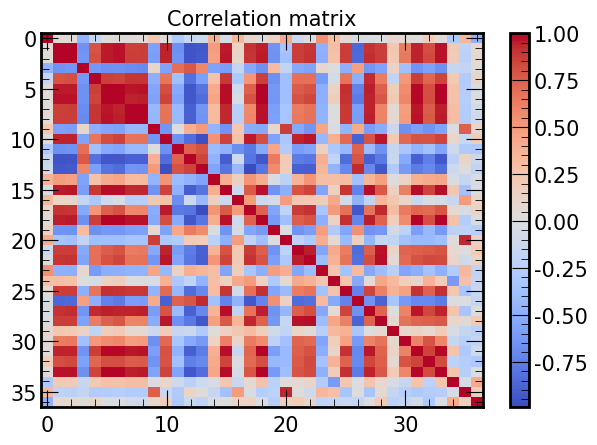

,Feature,Correlation
0,Label,1.000000
1,Gross capital formation (% of GDP),0.544342
2,"Inflation, GDP deflator (annual %)",0.412917
3,"Immunization, measles (% of children ages 12-2...",0.367727
4,Energy use (kg of oil equivalent per capita),0.340180
5,"Inflation, consumer prices (annual %)",0.333160
6,"Revenue, excluding grants (% of GDP)",0.288543
7,Income share held by lowest 20%,0.222303
8,"Foreign direct investment, net inflows (BoP, c...",0.186706
9,GDP growth (annual %),0.145926


In [3]:
# Analyse correlations with target variable
exclude_columns = ["Year", "Winner", "Party", "EC", "PV", "Era", "Lean"]
df_train = df.drop(columns=exclude_columns)

# Calculate correlation matrix
corr_matrix = df_train.corr()

# Plot
plt.figure()
plt.imshow(corr_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

# Show correlations with target label
corr_with_label = corr_matrix["Label"].sort_values(ascending=False)
corr_df = pd.DataFrame({
    "Feature": corr_with_label.index,
    "Correlation": corr_with_label.values
})

display(corr_df)

In [4]:
X = df_train.drop(columns=["Label"])
y = df_train["Label"]

print(f"{X.shape[1]} features, {X.shape[0]} samples")

36 features, 17 samples


## Container for performance metrics

In [5]:
metrics = {}

## Baseline logitistic regression


In [6]:
trainer = Train(X=X, y=y, model=LogisticRegression)

>**Note:** This baseline model is quite unstable. With only 17 elections and a 20% test split (3-4 elections), which specific elections end up in the test set dramatically affects performance. This is why LOOCV is used below for more reliable evaluation.

🚀 Training model: LogisticRegression
  Tag: lr-base
  Random state: 42
  Leave-One-Out CV: False
  Test size: 0.2
  Save output: False
  hyperparams: {}

  Test size: 0.2

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,2,0
True 1,1,1



⭐ Classification report:



,precision,recall,f1-score,support
0,0.666667,1.00,0.800000,2.00
1,1.000000,0.50,0.666667,2.00
accuracy,0.750000,0.75,0.750000,0.75
macro avg,0.833333,0.75,0.733333,4.00
weighted avg,0.833333,0.75,0.733333,4.00



⭐ ROC curve & feature importance:

✅ Wrote ../images/lr-base/roc_curve.png
✅ Wrote ../images/lr-base/roc_curve.png


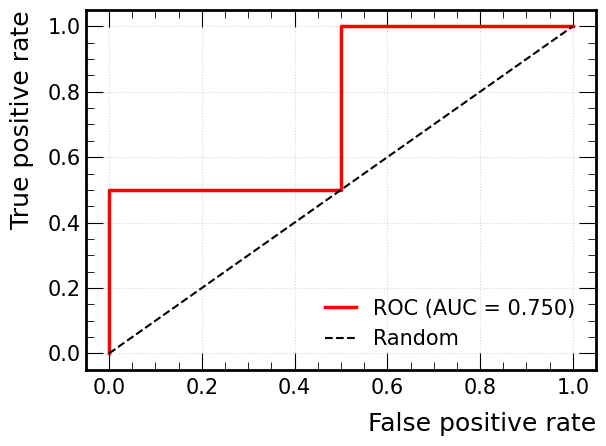

✅ Wrote ../images/lr-base/feature_importance.png


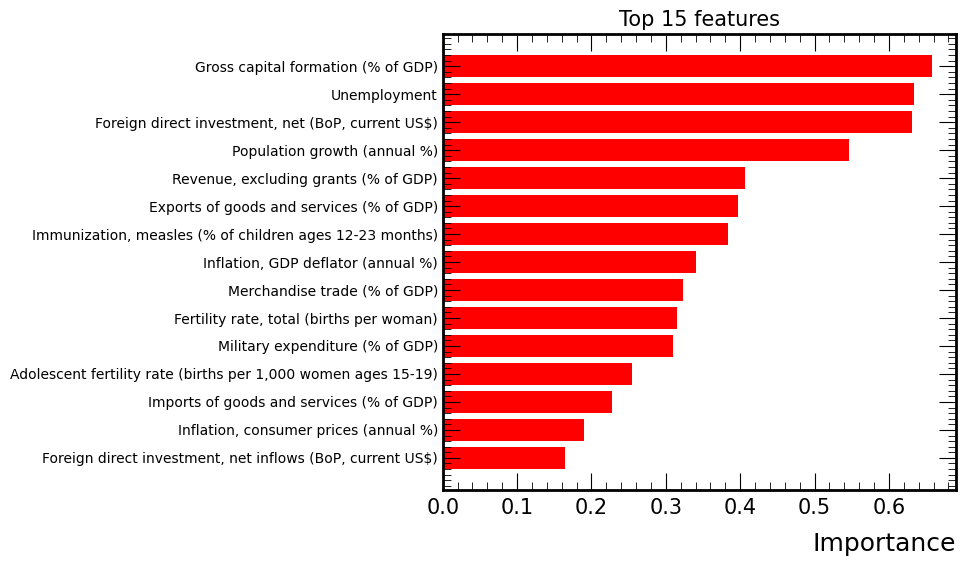

None

In [7]:
tag = "lr-base"
# Train model
results = trainer.train(
    loocv=False,
    random_state=42,
    test_size=0.2,
    tag = tag,
)
# Analyse and store metrics
# metrics[tag] = Analyse(results).execute()
_ = Analyse(results).execute(X=X, save_output=True)

## Logistic regression with leave-one-out cross validation (LOOCV)

Run with a test size of one in all combinations and get the average performance.

🚀 Training model: LogisticRegression
  Tag: lr-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.555556,0.625000,0.588235,8.000000
1,0.625000,0.555556,0.588235,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.590278,0.590278,0.588235,17.000000
weighted avg,0.592320,0.588235,0.588235,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/lr-loocv/roc_curve.png
✅ Wrote ../images/lr-loocv/roc_curve.png


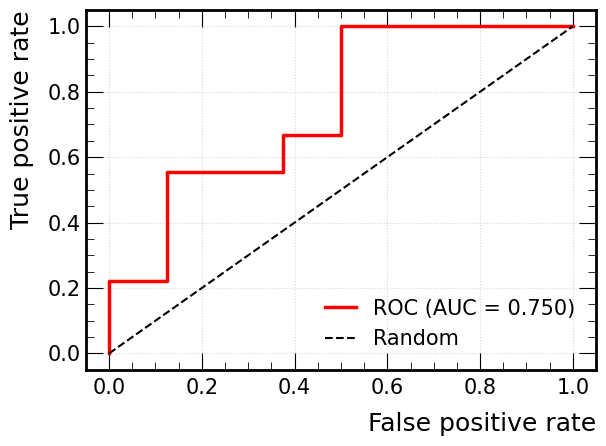

✅ Wrote ../images/lr-loocv/feature_importance.png


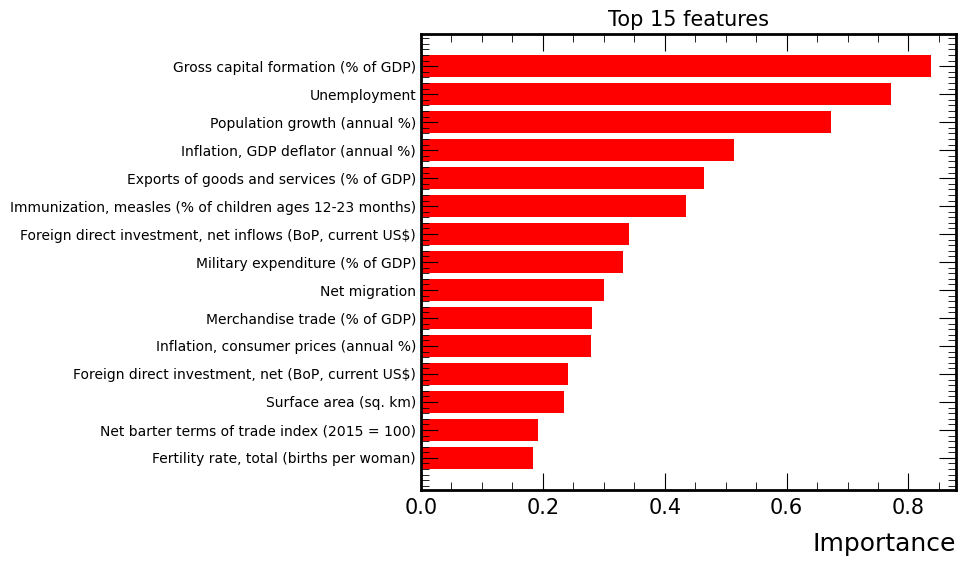

None

In [8]:
tag = "lr-loocv"
results = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
)
metrics[tag] = Analyse(results).execute(X=X, save_output=True) 

## Random forest classifier with LOOCV

🚀 Training model: RandomForestClassifier
  Tag: rf-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}

✅ Training complete.

⭐ Confusion matrix:

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,3,6



⭐ Classification report:



,precision,recall,f1-score,support
0,0.625000,0.625000,0.625000,8.000000
1,0.666667,0.666667,0.666667,9.000000
accuracy,0.647059,0.647059,0.647059,0.647059
macro avg,0.645833,0.645833,0.645833,17.000000
weighted avg,0.647059,0.647059,0.647059,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/rf-loocv/roc_curve.png
✅ Wrote ../images/rf-loocv/roc_curve.png


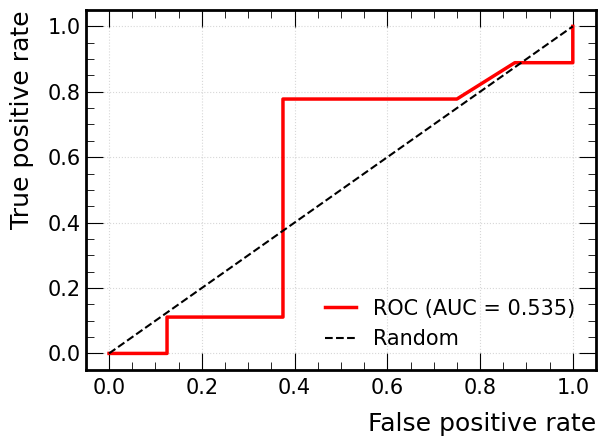

✅ Wrote ../images/rf-loocv/feature_importance.png


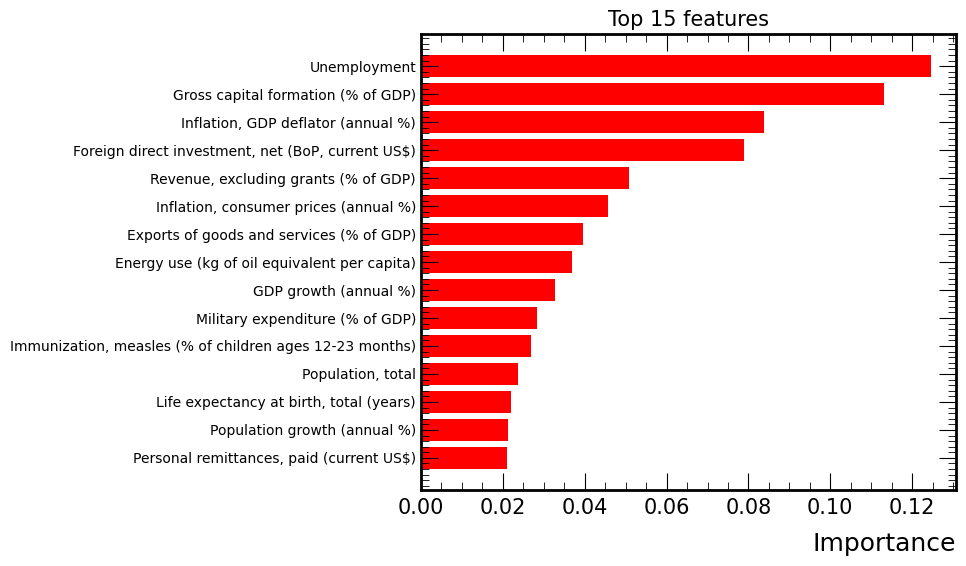

None

In [9]:
trainer = Train(X=X, y=y, model=RandomForestClassifier)

tag = "rf-loocv"
results = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
)
# Analysis
metrics[tag] = Analyse(results).execute(X=X, save_output=True) 

## Support vector machines with LOOCV

🚀 Training model: SVC
  Tag: svc-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {'probability': True, 'kernel': 'linear'}

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.555556,0.625000,0.588235,8.000000
1,0.625000,0.555556,0.588235,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.590278,0.590278,0.588235,17.000000
weighted avg,0.592320,0.588235,0.588235,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/svc-loocv/roc_curve.png
✅ Wrote ../images/svc-loocv/roc_curve.png


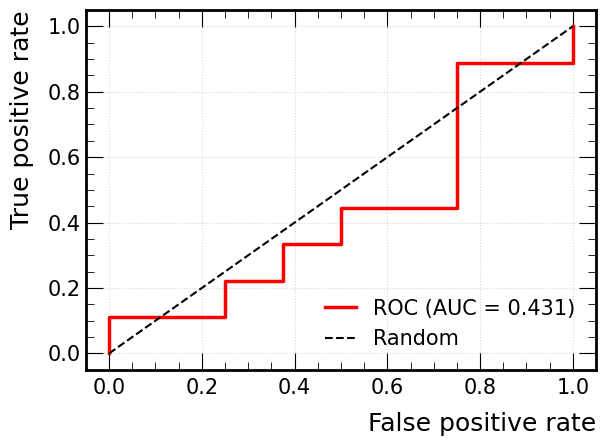

✅ Wrote ../images/svc-loocv/feature_importance.png


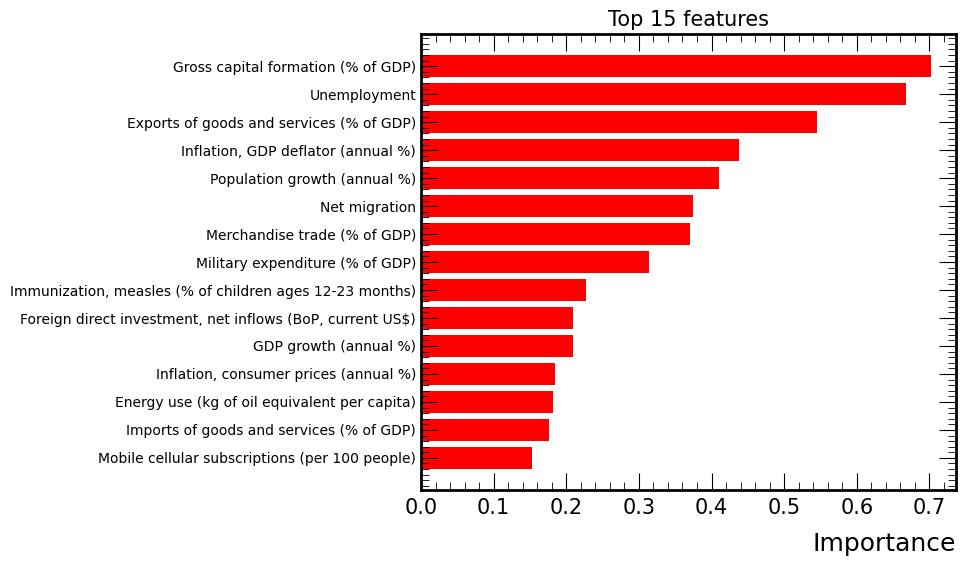

None

In [10]:
trainer = Train(X=X, y=y, model=SVC)
tag = "svc-loocv"
results = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag,
    probability=True,
    kernel="linear"
)
# Analysis
metrics[tag] = Analyse(results).execute(X=X, save_output=True)

## Gradient boosted decision tree with LOOCV

🚀 Training model: XGBClassifier
  Tag: xgb-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

✅ Training complete.

⭐ Confusion matrix:

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,4,4
True 1,3,6



⭐ Classification report:



,precision,recall,f1-score,support
0,0.571429,0.500000,0.533333,8.000000
1,0.600000,0.666667,0.631579,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.585714,0.583333,0.582456,17.000000
weighted avg,0.586555,0.588235,0.585346,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/xgb-loocv/roc_curve.png
✅ Wrote ../images/xgb-loocv/roc_curve.png


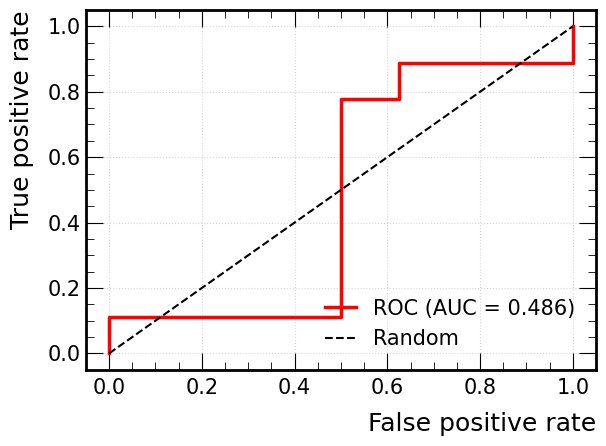

✅ Wrote ../images/xgb-loocv/feature_importance.png


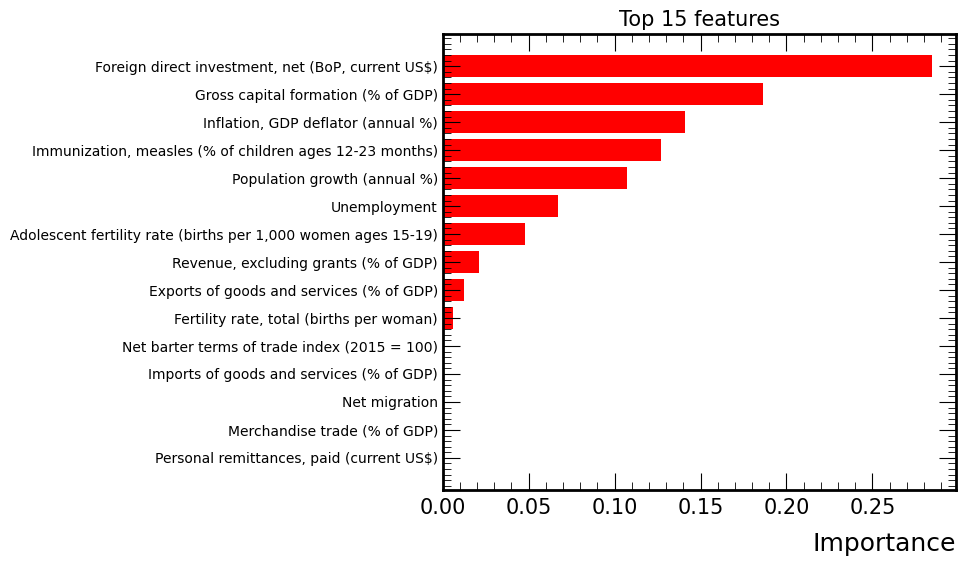

None

In [11]:
trainer = Train(X=X, y=y, model=XGBClassifier)
tag = "xgb-loocv"
results = trainer.train(
    loocv=True,
    random_state=42,
    tag=tag,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1
)
# Analysis
metrics[tag] = Analyse(results).execute(X=X, save_output=True) 

## Compare performance

✅ Wrote ../images/metrics_comparison.png


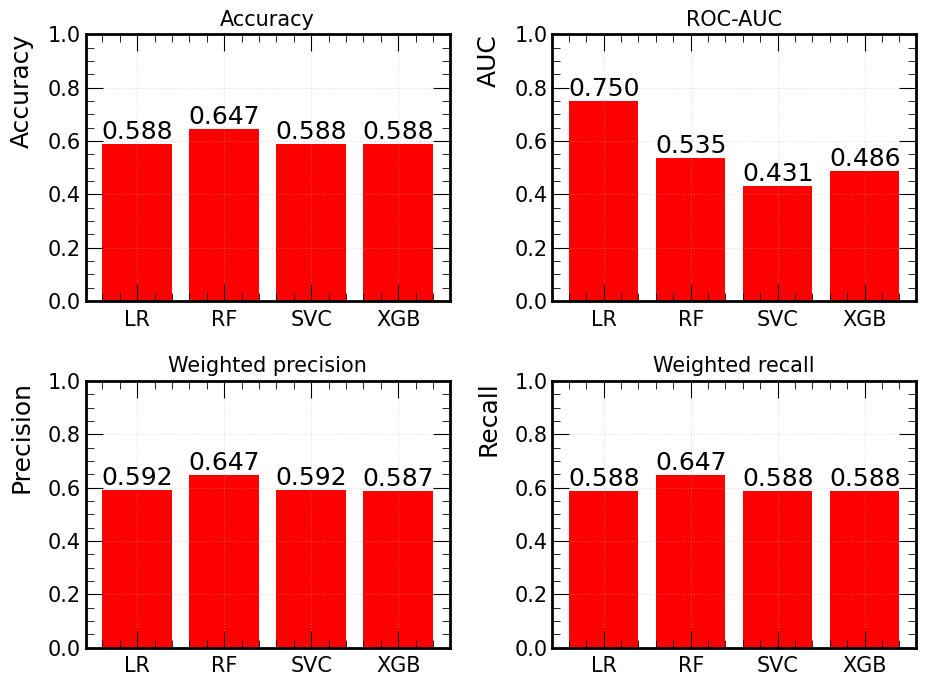

In [12]:
# Bar charts of multiple metrics for each model
df_metrics = pd.DataFrame(metrics).T

fig, ax = plt.subplots(2, 2, figsize=(1.5*6.4, 1.5*4.8))

labels = ["LR", "RF", "SVC", "XGB"]
acc = []
auc = []
precision = []
recall = []

for x in metrics.values():
    report = x["report"]
    acc.append(report.loc["accuracy", "precision"])
    auc.append(x["roc"]["auc"])
    # Weighted average of precision and recall across classes
    precision.append(report.loc["weighted avg", "precision"])
    recall.append(report.loc["weighted avg", "recall"])

# Plot accuracy
bars = ax[0, 0].bar(labels, acc)
ax[0, 0].set_ylabel("Accuracy")
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_title("Accuracy")
ax[0, 0].grid(alpha=0.4)
for bar in bars:
    height = bar.get_height()
    ax[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.3f}', ha='center', va='bottom')

# Plot AUC
bars = ax[0, 1].bar(labels, auc)
ax[0, 1].set_ylabel("AUC")
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_title("ROC-AUC")
ax[0, 1].grid(alpha=0.4)
for bar in bars:
    height = bar.get_height()
    ax[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.3f}', ha='center', va='bottom') #, fontsize=9)

# Plot Precision
bars = ax[1, 0].bar(labels, precision)
ax[1, 0].set_ylabel("Precision")
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_title("Weighted precision")
ax[1, 0].grid(alpha=0.4)
for bar in bars:
    height = bar.get_height()
    ax[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.3f}', ha='center', va='bottom') #, fontsize=9)

# Plot Recall
bars = ax[1, 1].bar(labels, recall)
ax[1, 1].set_ylabel("Recall")
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_title("Weighted recall")
ax[1, 1].grid(alpha=0.4)
for bar in bars:
    height = bar.get_height()
    ax[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.3f}', ha='center', va='bottom') #, fontsize=9)

plt.tight_layout()

file_name = "../images/metrics_comparison.png"
plt.savefig(file_name)
print(f"✅ Wrote {file_name}")
plt.show()

## Optimisation

Based on this, a shallow random forest is likely the most reliable approach, although logistic regression has the best seperation. We are struggling with the small sample size here.  

Feature engineering

* Reduce the number of features 
* Try interaction terms
* Recursive feature elimination

Hyperparameter tuning 

```
param_grid = {
    'n_estimators': [50, 100, 200],         # More trees, more stable
    'max_depth': [2, 3, 4, 5],              # SHALLOW to prevent overfitting
    'min_samples_split': [2, 3, 4],         # Higher: less overfitting
    'min_samples_leaf': [1, 2, 3],          # Higher: smoother decision boundaries
    'max_features': ['sqrt', 'log2', 0.5],  # Limit features per split
    'bootstrap': [True],                     # Variance reduction
}
```

Selected features:
:Population growth (annual %)
:Fertility rate, total (births per woman)
:Immunization, measles (% of children ages 12-23 months)
:Energy use (kg of oil equivalent per capita)
:Inflation, GDP deflator (annual %)
:Gross capital formation (% of GDP)
:Revenue, excluding grants (% of GDP)
:Foreign direct investment, net (BoP, current US$)
:Inflation, consumer prices (annual %)
:Unemployment
🚀 Training model: LogisticRegression
  Tag: rf-loocv-sel
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,6,2
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.600000,0.750000,0.666667,8.000000
1,0.714286,0.555556,0.625000,9.000000
accuracy,0.647059,0.647059,0.647059,0.647059
macro avg,0.657143,0.652778,0.645833,17.000000
weighted avg,0.660504,0.647059,0.644608,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/rf-loocv-sel/roc_curve.png
✅ Wrote ../images/rf-loocv-sel/roc_curve.png


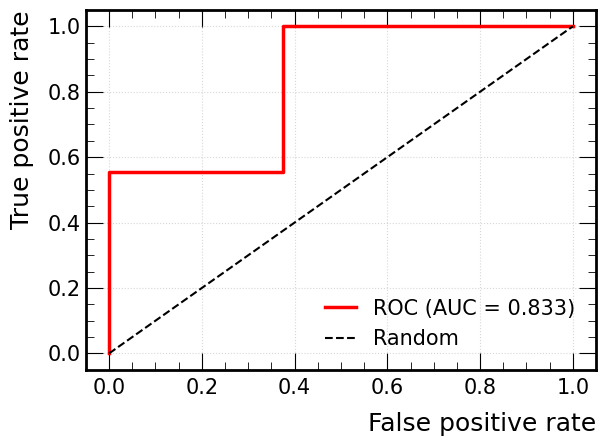

✅ Wrote ../images/rf-loocv-sel/feature_importance.png


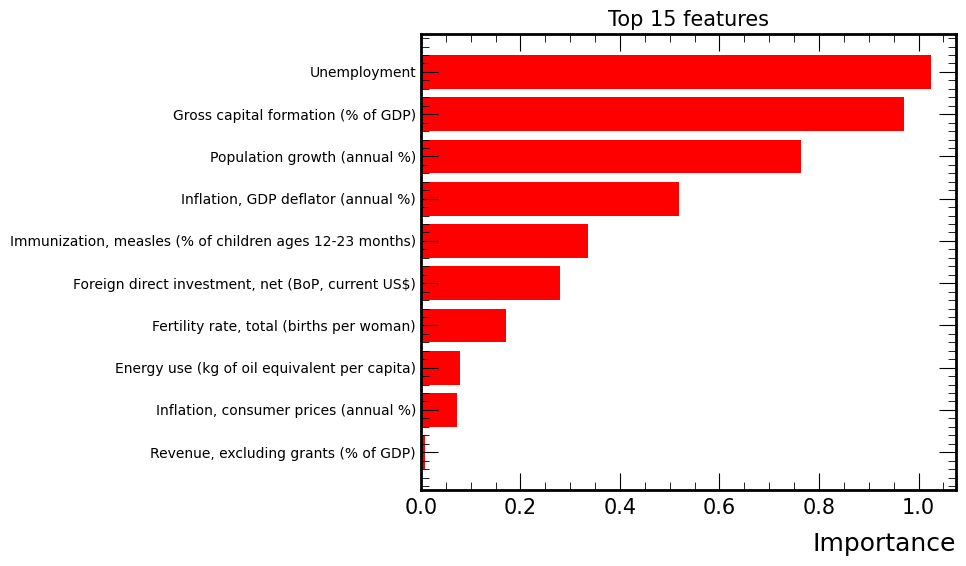

None

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 10 features based on ANOVA F-statistic
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:")
for feature in selected_features:
    print(f":{feature}")

# Training with selected features
trainer = Train(X=X[selected_features], y=y, model=LogisticRegression)

tag = "rf-loocv-sel"
results = trainer.train(
    loocv=True,
    random_state=42,
    tag = tag, 
)
metrics[tag] = Analyse(results).execute(X=X[selected_features], save_output=True) 

This is big improvement in AUC! I guess it filters out some of the noise and lets the model calibrate probabilties better

##  Now try interaction terms

In [14]:
from sklearn.preprocessing import PolynomialFeatures

# Start with the 10 selected features for cleaner interaction terms
# Create interaction terms (degree=2 means products of pairs, no polynomials)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X[selected_features])

# Get feature names
interaction_feature_names = poly.get_feature_names_out(selected_features)
print(f"Original features: {len(selected_features)}")
print(f"With interactions: {len(interaction_feature_names)}")

# Create DataFrame with interaction features
X_interact = pd.DataFrame(X_interactions, columns=interaction_feature_names, index=X.index)

# Display a few interaction terms
print(f"\nSample interaction features:")
print(interaction_feature_names[10:20])

Original features: 10
With interactions: 55

Sample interaction features:
['Population growth (annual %) Fertility rate, total (births per woman)'
 'Population growth (annual %) Immunization, measles (% of children ages 12-23 months)'
 'Population growth (annual %) Energy use (kg of oil equivalent per capita)'
 'Population growth (annual %) Inflation, GDP deflator (annual %)'
 'Population growth (annual %) Gross capital formation (% of GDP)'
 'Population growth (annual %) Revenue, excluding grants (% of GDP)'
 'Population growth (annual %) Foreign direct investment, net (BoP, current US$)'
 'Population growth (annual %) Inflation, consumer prices (annual %)'
 'Population growth (annual %) Unemployment'
 'Fertility rate, total (births per woman) Immunization, measles (% of children ages 12-23 months)']


🚀 Training model: RandomForestClassifier
  Tag: rf-loocv-interact
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}

✅ Training complete.

⭐ Confusion matrix:

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,6,2
True 1,3,6



⭐ Classification report:



,precision,recall,f1-score,support
0,0.666667,0.750000,0.705882,8.000000
1,0.750000,0.666667,0.705882,9.000000
accuracy,0.705882,0.705882,0.705882,0.705882
macro avg,0.708333,0.708333,0.705882,17.000000
weighted avg,0.710784,0.705882,0.705882,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/rf-loocv-interact/roc_curve.png
✅ Wrote ../images/rf-loocv-interact/roc_curve.png


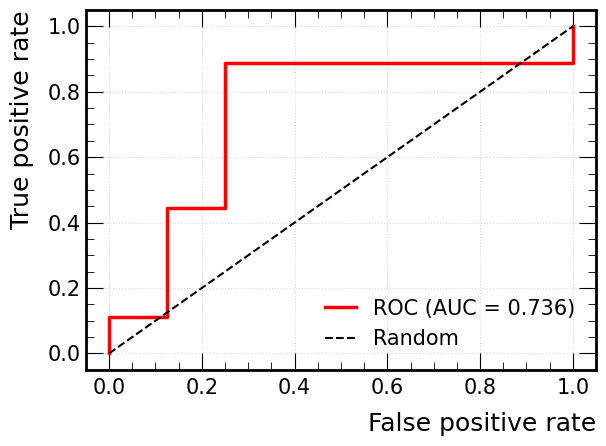

✅ Wrote ../images/rf-loocv-interact/feature_importance.png


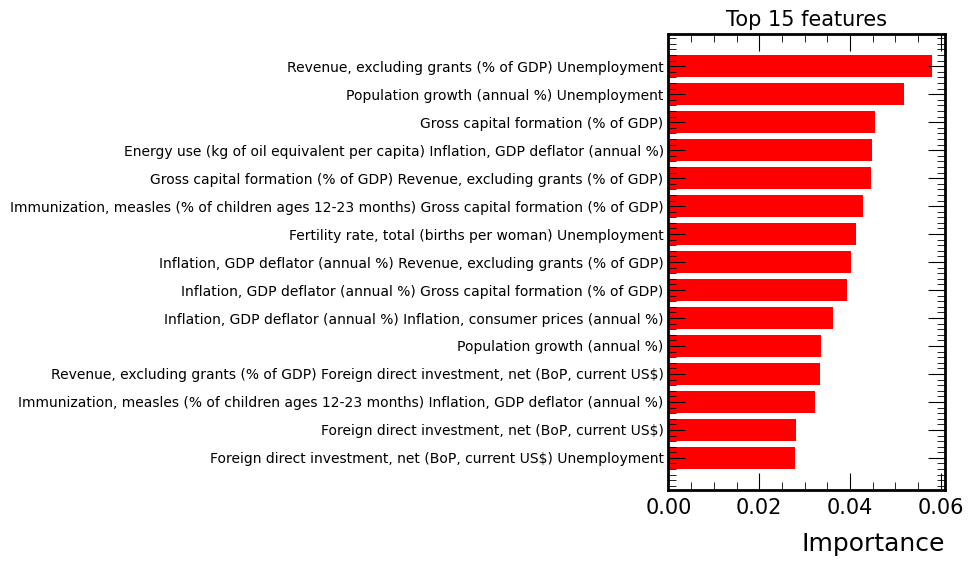

None

In [15]:
# Train Random Forest with interaction features
trainer = Train(X=X_interact, y=y, model=RandomForestClassifier)

tag = "rf-loocv-interact"
results = trainer.train(
    loocv=True,
    random_state=42,
    tag=tag,
)
metrics[tag] = Analyse(results).execute(X=X_interact, save_output=True)

Selected 15 features from 55 total

Selected features (base + interactions):
  Population growth (annual %)
  Inflation, GDP deflator (annual %)
  Gross capital formation (% of GDP)
  Unemployment
  Population growth (annual %) Fertility rate, total (births per woman)
  Population growth (annual %) Immunization, measles (% of children ages 12-23 months)
  Population growth (annual %) Unemployment
  Fertility rate, total (births per woman) Unemployment
  Immunization, measles (% of children ages 12-23 months) Energy use (kg of oil equivalent per capita)
  Immunization, measles (% of children ages 12-23 months) Inflation, GDP deflator (annual %)
  Immunization, measles (% of children ages 12-23 months) Gross capital formation (% of GDP)
  Energy use (kg of oil equivalent per capita) Gross capital formation (% of GDP)
  Inflation, GDP deflator (annual %) Gross capital formation (% of GDP)
  Inflation, GDP deflator (annual %) Revenue, excluding grants (% of GDP)
  Gross capital formation (

,Predicted 0,Predicted 1
True 0,7,1
True 1,1,8



⭐ Classification report:



,precision,recall,f1-score,support
0,0.875000,0.875000,0.875000,8.000000
1,0.888889,0.888889,0.888889,9.000000
accuracy,0.882353,0.882353,0.882353,0.882353
macro avg,0.881944,0.881944,0.881944,17.000000
weighted avg,0.882353,0.882353,0.882353,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/rf-loocv-interact-sel/roc_curve.png
✅ Wrote ../images/rf-loocv-interact-sel/roc_curve.png


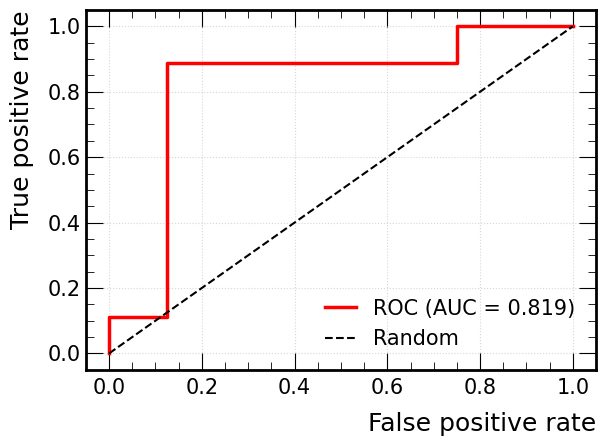

✅ Wrote ../images/rf-loocv-interact-sel/feature_importance.png


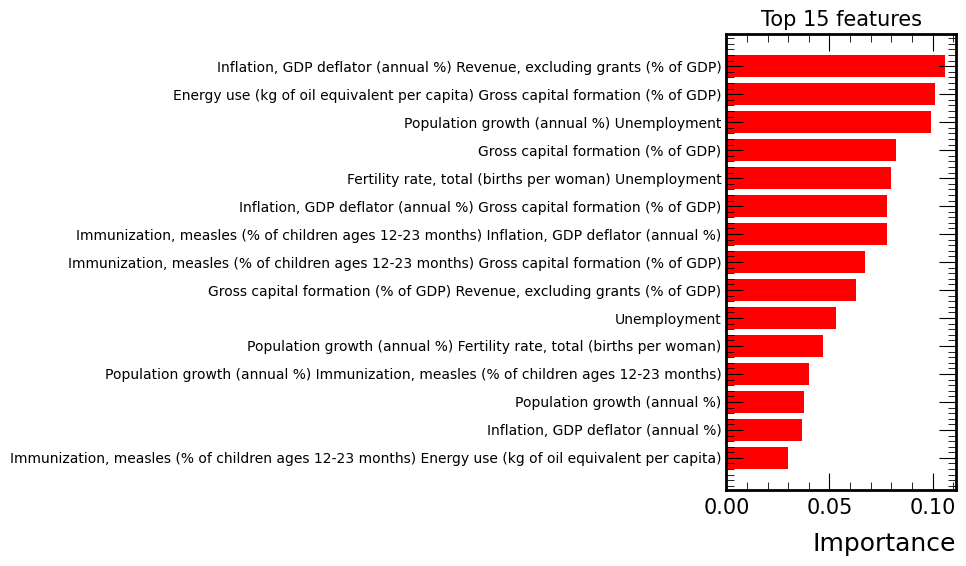

None

In [16]:
# Select best features from interactions (including base features)
selector_interact = SelectKBest(score_func=f_classif, k=15)
X_interact_selected = selector_interact.fit_transform(X_interact, y)

# Get selected feature names
selected_interact_features = X_interact.columns[selector_interact.get_support()]
print(f"Selected {len(selected_interact_features)} features from {len(X_interact.columns)} total")
print("\nSelected features (base + interactions):")
for feature in selected_interact_features:
    print(f"  {feature}")

# Train with selected interactions
trainer = Train(X=X_interact[selected_interact_features], y=y, model=RandomForestClassifier)

tag = "rf-loocv-interact-sel"
results = trainer.train(
    loocv=True,
    random_state=42,
    tag=tag,
)
metrics[tag] = Analyse(results).execute(X=X_interact[selected_interact_features], save_output=True)

## Hyperparameter tuning

Tune the Random Forest hyperparameters with the selected interaction features

In [19]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
}

# Use selected interaction features
X_tune = X_interact[selected_interact_features]

# Grid search with LOOCV
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=LeaveOneOut(),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Running grid search (this may take a few minutes)...")
grid_search.fit(X_tune, y)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")

Running grid search (this may take a few minutes)...
Fitting 17 folds for each of 216 candidates, totalling 3672 fits

Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.882

Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.882


/home/sam/miniconda3/envs/ana_v2.4.0/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


🚀 Training model: RandomForestClassifier
  Tag: rf-loocv-interact-sel-tuned
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

✅ Training complete.

⭐ Confusion matrix:

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,7,1
True 1,1,8



⭐ Classification report:



,precision,recall,f1-score,support
0,0.875000,0.875000,0.875000,8.000000
1,0.888889,0.888889,0.888889,9.000000
accuracy,0.882353,0.882353,0.882353,0.882353
macro avg,0.881944,0.881944,0.881944,17.000000
weighted avg,0.882353,0.882353,0.882353,17.000000



⭐ ROC curve & feature importance:

✅ Wrote ../images/rf-loocv-interact-sel-tuned/roc_curve.png
✅ Wrote ../images/rf-loocv-interact-sel-tuned/roc_curve.png


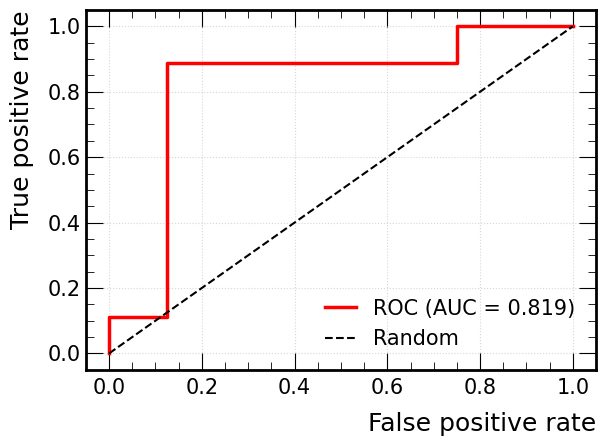

✅ Wrote ../images/rf-loocv-interact-sel-tuned/feature_importance.png


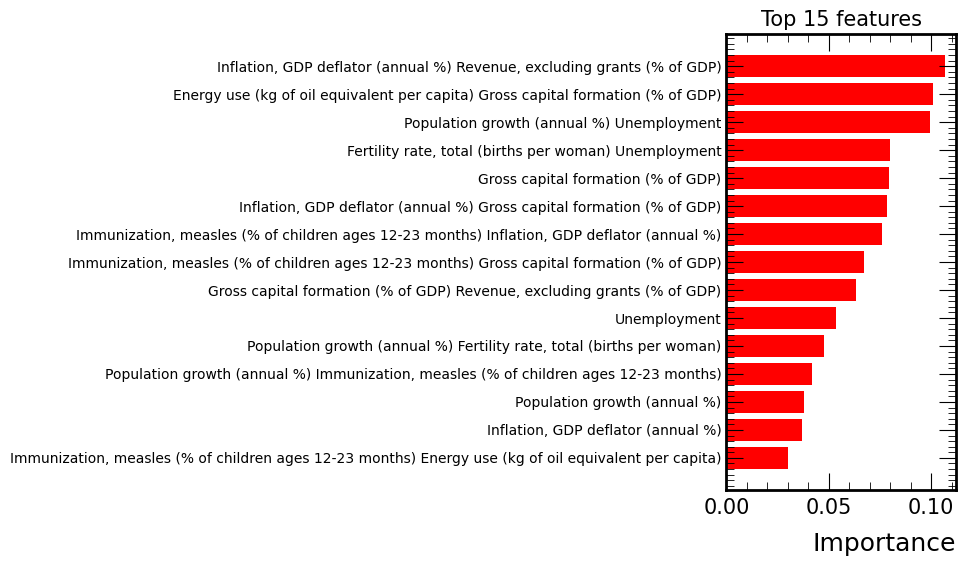

None

In [22]:
# Train final model with best parameters
trainer = Train(X=X_tune, y=y, model=RandomForestClassifier)

tag = "rf-loocv-interact-sel-tuned"
results = trainer.train(
    loocv=True,
    random_state=42,
    tag=tag,
    **grid_search.best_params_
)
metrics[tag] = Analyse(results).execute(X=X_tune, save_output=True)

Makes no difference at all, which is not a bad thing

In [ ]:
# Analyse misclassifications
y_test = np.array(results['y_test'])
y_pred = np.array(results['y_pred'])
y_proba = np.array(results['y_proba'])

# Find indices of misclassified samples
error_mask = y_test != y_pred
error_indices = np.where(error_mask)[0]

print(f"Misclassified elections: {len(error_indices)}/{len(y_test)}\n")


if len(error_indices) > 0: 
    print("Misclassified elections:")
    for idx in error_indices:
        year = df.iloc[idx]['Year']
        winner = df.iloc[idx]['Winner']
        party = df.iloc[idx]['Party']
        actual = "Right" if y_test[idx] == 1 else "Left"
        predicted = "Right" if y_pred[idx] == 1 else "Left"
        confidence = y_proba[idx]
        
        print(f"  {year} - {winner} ({party})")
        print(f"    Actual: {actual}, Predicted: {predicted}")
        print(f"    Confidence (prob of Right): {confidence:.3f}\n")
else:
    print("No misclassifications!")

Misclassified elections: 2/17

Misclassified elections:
  2016 - Donald Trump (Republican)
    Actual: Right, Predicted: Left
    Confidence (prob of Right): 0.140

  1976 - Jimmy Carter (Democratic)
    Actual: Left, Predicted: Right
    Confidence (prob of Right): 0.880



2016 - Trump (R):

Predicted Left with 86% confidence (0.140 prob of Right). The model was fooled by economic conditions that seem to typically favor Democrats. Trump 2016 was an interesting election driven by factors not captured in macroeconomic data.


1976 - Carter (D):

Predicted Right with 88% confidence. Post-Watergate, post-Vietnam era with unique political circumstances. His long-shot status at the beginning of his campaign led to the common question and eventual nickname "Jimmy Who?". 

## Economic conditions vs election outcomes

Analyze which economic conditions favor Left vs Right outcomes

Plotting 10 features


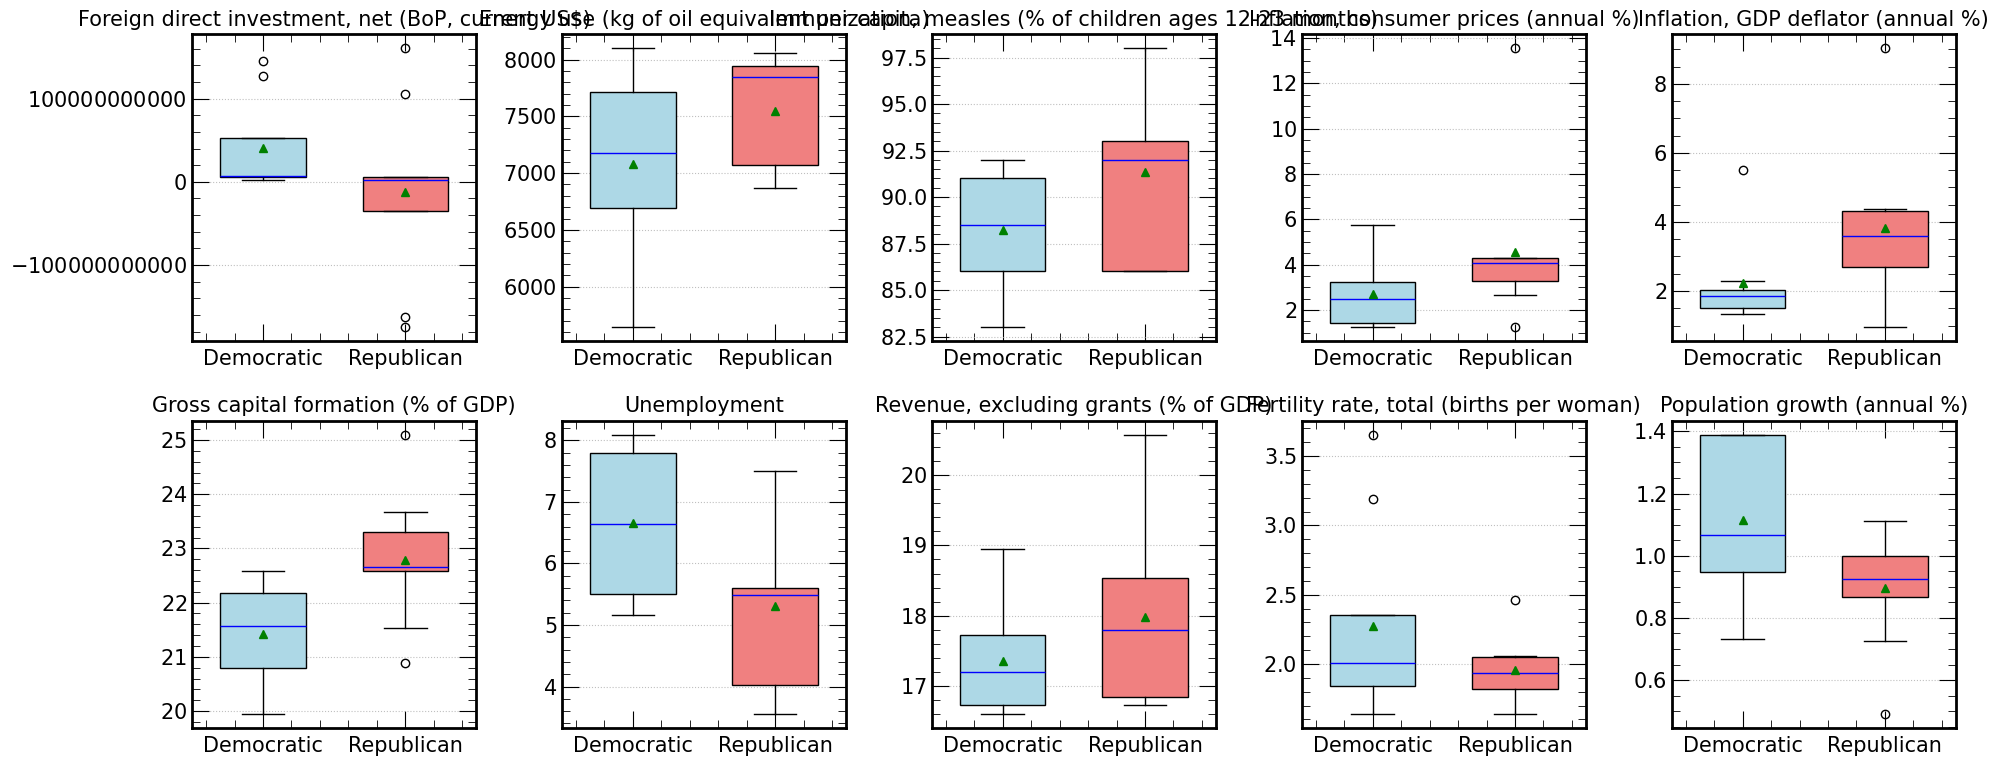

Saved: ../images/economic_conditions_by_outcome.png


In [ ]:
# Visualise the top features that distinguish Left vs Right outcomes
# Extract unique base feature names from the comparison (removes _mean/_median duplicates)
top_features = []
for feat in comparison.index:
    base_name = feat.replace('_mean', '').replace('_median', '')
    if base_name in selected_features and base_name not in top_features:
        top_features.append(base_name)
        if len(top_features) == 10:
            break

print(f"Plotting {len(top_features)} features")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    left_data = df[df['Label'] == 0][feature]
    right_data = df[df['Label'] == 1][feature]
    
    positions = [1, 2]
    bp = ax.boxplot([left_data, right_data], positions=positions, widths=0.6,
                     patch_artist=True, showmeans=True)
    
    # Color boxes
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_xticks(positions)
    ax.set_xticklabels(['Democratic', 'Republican'])
    ax.set_title(feature) #, fontsize=10)
    ax.grid(axis='y') #, alpha=0.3)
    
    # # Use scientific notation with useMathText to place offset in xlabel area
    # ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1e3,1e3), useMathText=True)
    # ax.yaxis.set_offset_position('left')

# Hide any unused subplots
for idx in range(len(top_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('../images/economic_conditions_by_outcome.png') #, dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: ../images/economic_conditions_by_outcome.png")